### **Project Details**
The core objective of this project is to conduct a comprehensive analysis of Airbnb listings in New York City. The approach involves integrating two distinct data sources: structured data, which includes information on pricing, location, and property features; and unstructured data, which consists of a large corpus of guest reviews. By combining these datasets, the project aims to identify key insights, such as how guest sentiment and a listing's proximity to public transit influence its price. Due to the complex nature of the data—which combines both text and numeric features—the project scope may be subject to refinement as new analytical challenges or opportunities are discovered.


#### **Step 1: Set Up and Load Data**

In [11]:
import pandas as pd
import requests
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
nltk.download("vader_lexicon", quiet=True)
sia = SentimentIntensityAnalyzer()

# These are the original data links
LISTINGS_URL  = "https://data.insideairbnb.com/united-states/ny/new-york-city/2025-08-09/data/listings.csv.gz"
REVIEWS_URL   = "https://data.insideairbnb.com/united-states/ny/new-york-city/2025-08-09/data/reviews.csv.gz"
GTFS_URL      = "http://web.mta.info/developers/data/nyct/subway/google_transit.zip"

In [13]:
listings_response = requests.get(LISTINGS_URL)
reviews_response = requests.get(REVIEWS_URL)
gtfs_response = requests.get(GTFS_URL)

#### The website blocked direct downloads, so now we are loading from local files. So here need to load the file that have downloaded from the website. 

In [14]:
# Load already unzipped CSV files
listings_df = pd.read_csv("listings.csv")
reviews_df = pd.read_csv("reviews.csv")
subway_df = pd.read_csv("MTA_Subway_Stations_20250904.csv")

print("Listings:", listings_df.shape)
print("Reviews:", reviews_df.shape)
print("Subway stations:", subway_df.shape)

Listings: (459, 79)
Reviews: (26918, 6)
Subway stations: (496, 19)


### **WEEK: 3**
### **Step 2: Clean and Merge Data** 
This step cleans the price data by removing dollar signs and outliers. Then, it merges the listings with the reviews data. This combined DataFrame, merged_df, is what you'll use for sentiment analysis in the next step.

In [15]:
# Clean the 'price' column by removing the dollar sign and converting to a number.
listings_df["price"] = listings_df["price"].astype(str).str.replace('$', '').str.replace(',', '').astype(float)

# Use the Interquartile Range (IQR) method to remove price outliers.
Q1 = listings_df["price"].quantile(0.25)
Q3 = listings_df["price"].quantile(0.75)
IQR = Q3 - Q1
listings_df = listings_df[
    (listings_df["price"] >= Q1 - 1.5*IQR) &
    (listings_df["price"] <= Q3 + 1.5*IQR)
]

# Merge the listings and reviews dataframes.
merged_df = pd.merge(listings_df, reviews_df, left_on='id', right_on='listing_id', how='left')

print("Data cleaned and merged.")




Data cleaned and merged.


### **WEEK 4:**
### **Step 3: Engineer New Features**
This is the most critical part of your analysis. It transforms the raw data into usable features. This code first uses VADER to calculate a sentiment score for each review, then averages the scores to create avg_sentiment. It also uses cKDTree to efficiently calculate the distance to the nearest subway station for each listing and adds it as a new column, distance_to_subway.

In [16]:
# Load VADER lexicon for sentiment analysis.
nltk.download("vader_lexicon", quiet=True)
sia = SentimentIntensityAnalyzer()

# Score each review comment.
merged_df['sentiment_score'] = merged_df['comments'].apply(lambda comment: sia.polarity_scores(str(comment))['compound'])

# Calculate the average sentiment score per listing.
review_scores = merged_df.groupby("listing_id")["sentiment_score"].mean().reset_index()
review_scores.rename(columns={"sentiment_score": "avg_sentiment"}, inplace=True)

# Count reviews for each listing.
review_counts = merged_df.groupby('listing_id').size().reset_index(name='review_count')

# Merge all new features into the main dataframe.
listings_with_features = pd.merge(listings_df, review_scores, left_on='id', right_on='listing_id', how='left')
listings_with_features = pd.merge(listings_with_features, review_counts, left_on='id', right_on='listing_id', how='left')

# Fill missing sentiment and review counts with neutral values.
listings_with_features['avg_sentiment'] = listings_with_features['avg_sentiment'].fillna(0)
listings_with_features['review_count'] = listings_with_features['review_count'].fillna(0)

# Create a review count bucket feature.
bins = [0, 1, 5, 20, 50, 100, float('inf')]
labels = ['1', '2-5', '6-20', '21-50', '51-100', '101+']
listings_with_features['review_count_bucket'] = pd.cut(listings_with_features['review_count'], bins=bins, labels=labels, right=False)

# Extract listing and subway coordinates.
listing_coords = listings_with_features[["latitude", "longitude"]].to_numpy()
subway_coords = subway_df[["GTFS Latitude", "GTFS Longitude"]].to_numpy()

# Build KDTree for fast nearest-neighbor search.
tree = cKDTree(subway_coords)
distances, _ = tree.query(listing_coords, k=1)

# Convert from degrees to meters and add as a new column.
listings_with_features["distance_to_subway"] = distances * 111000

# Perform one-hot encoding for property types.
listings_with_features['property_type_simp'] = listings_with_features['property_type'].str.replace('private room in ', '', regex=False).str.replace('room in ', '', regex=False).str.replace('Entire ', '', regex=False).str.replace('Private room in ', '', regex=False).str.replace('Shared room in ', '', regex=False).str.replace('Hotel room in ', '', regex=False).str.replace('Hotel room ', '', regex=False)
one_hot_encoded_df = pd.get_dummies(listings_with_features['property_type_simp'], prefix='property')
listings_with_features = pd.concat([listings_with_features, one_hot_encoded_df], axis=1)

print("Step 2 complete: All features engineered and merged.")

Step 2 complete: All features engineered and merged.


In [30]:
missing = [col for col in features if col not in df.columns]
print("Missing features:", missing)
print("Available columns:", df.columns.tolist()[:30])  # show first 30 for reference


Missing features: ['property_type', 'property_type_simp']
Available columns: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']


In [31]:
# Core features
features = [
    "latitude", 
    "longitude", 
    "avg_sentiment",      # numeric sentiment feature
    "distance_to_subway"  # numeric distance feature
]

# Dynamically add one-hot encoded property type features
property_cols = [col for col in df.columns if col.startswith("property_")]
features += property_cols

# Build feature matrix and targets
X = df[features].copy()
y_reg = np.log1p(df["price"])  # regression target
y_clf = (df["price"] > df["price"].median()).astype(int)  # classification target


In [33]:
# Import pandas to work with the DataFrame
import pandas as pd

# Load the final dataset from Week 4
df = pd.read_csv('nyc_airbnb_features_week4.csv')

# Print the data types of all columns
print(df.dtypes)

id                          int64
listing_url                object
scrape_id                   int64
last_scraped               object
source                     object
                           ...   
property_townhouse           bool
property_vacation home       bool
sentiment_score_scaled    float64
transit_score             float64
quality_score             float64
Length: 107, dtype: object


In [39]:
# Import all necessary libraries at the beginning
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

# Load the final dataset from Week 4
df = pd.read_csv('nyc_airbnb_features_week4.csv')

# --- Step 1: Data Preparation with a Pipeline ---

# Define the numerical features to be used for the model
numerical_features = [
    'sentiment_score_scaled',
    'transit_score',
    'accommodates',
    'bedrooms',
    'beds',
    'review_count',
]

# Ensure these columns are numerical, coercing errors to NaN
for col in numerical_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Dynamically find all one-hot encoded property columns.
property_features = df.filter(like='property_').columns.tolist()

# Define the target variable (y), which is the price
target = 'price'

# Create the feature matrix (X) and the target vector (y)
X = df[numerical_features + property_features]
y = df[target]

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a preprocessing pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Identify columns by their type
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
boolean_cols = X_train.select_dtypes(include='bool').columns.tolist()

print("\n--- Diagnostic Check of Column Types ---")
print(f"Number of numerical columns: {len(numeric_cols)}")
print(f"Number of boolean columns: {len(boolean_cols)}")
print("---------------------------------------")

# Use ColumnTransformer to apply the correct preprocessing
# This is a more robust way to handle data types automatically
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('prop', 'passthrough', boolean_cols)
    ])

# Create the full machine learning pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

print("\nStep 1: Data preparation pipeline created.")
print(f"Training set size: {X_train.shape[0]} samples")

# --- Step 2: Train the Model ---
# The pipeline handles all preprocessing and training in one step
model_pipeline.fit(X_train, y_train)
print("\nStep 2: Model training complete.")

# --- Step 3: Evaluate the Model ---
# The pipeline handles preprocessing and prediction in one step
y_pred = model_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print("\nStep 3: Model evaluation complete.")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")

# Look at the model's coefficients to see which features matter most
print("\nModel Coefficients:")
# The coefficients are stored within the pipeline's regressor step
coefficients = model_pipeline.named_steps['regressor'].coef_
# The order of features in the final pipeline output will match the order in `numeric_cols` then `boolean_cols`
final_features = numeric_cols + boolean_cols
for feature, coef in zip(final_features, coefficients):
    print(f"{feature}: {coef:.2f}")


--- Diagnostic Check of Column Types ---
Number of numerical columns: 6
Number of boolean columns: 18
---------------------------------------

Step 1: Data preparation pipeline created.
Training set size: 304 samples

Step 2: Model training complete.

Step 3: Model evaluation complete.
Mean Absolute Error (MAE): $16.95

Model Coefficients:
sentiment_score_scaled: -0.11
transit_score: -1.26
accommodates: 10.81
bedrooms: 6.71
beds: 2.64
review_count: 1.12
property_Private bed and breakfast: 41.19
property_Private condo: 18.11
property_Private guest suite: -35.57
property_Private home: -22.32
property_Private rental unit: -32.18
property_Private townhouse: -48.32
property_Private villa: -66.03
property_Room in aparthotel: 0.00
property_Room in hotel: 76.19
property_condo: 5.28
property_cottage: 31.31
property_guest suite: 20.71
property_home: 8.42
property_loft: -25.20
property_place: 23.83
property_rental unit: -1.82
property_townhouse: -1.52
property_vacation home: 7.94


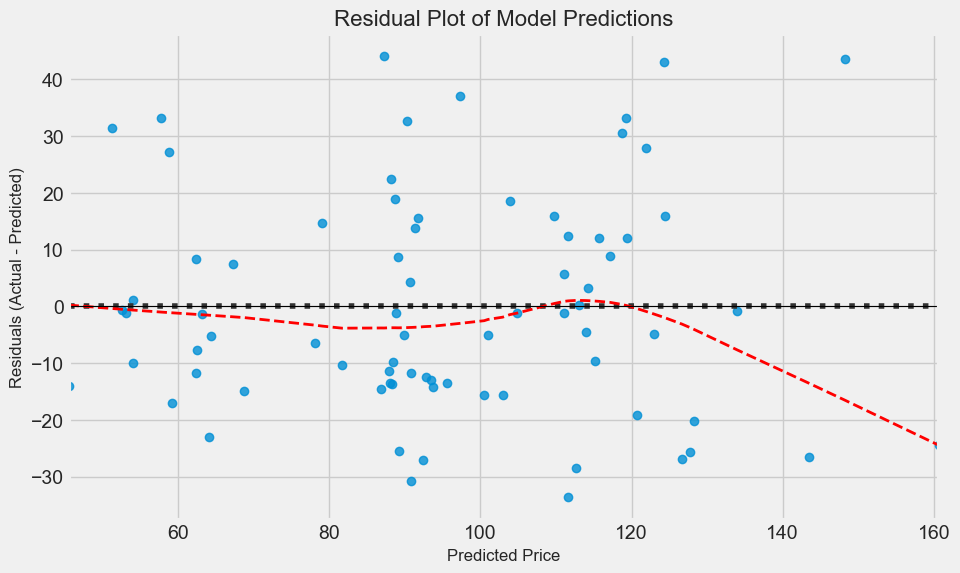

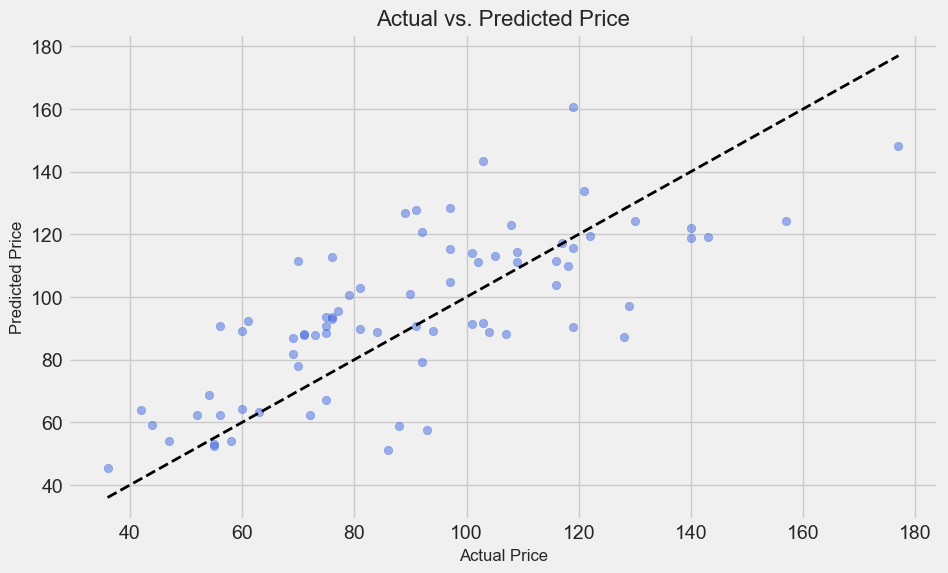

Week 6 complete: Model performance has been visualized and evaluated.
The residual plot shows how the errors are distributed.
The actual vs. predicted plot shows the model's overall accuracy.

Next steps (Week 7):
1. Draft your findings based on the model coefficients and visualizations.
2. Prepare visualizations for your final report, such as a bar chart of property types and their average prices.


In [40]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a style for the plots
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# --- Step 1: Calculate residuals ---
# Residuals are the differences between the actual price and the predicted price
y_pred = model_pipeline.predict(X_test)
residuals = y_test - y_pred

# --- Step 2: Create a Residual Plot ---
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2, 'ls': '--'})
plt.title('Residual Plot of Model Predictions', fontsize=16)
plt.xlabel('Predicted Price', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.show()

# --- Step 3: Create an Actual vs. Predicted Price Plot ---
plt.figure(figsize=(10, 6))
plt.scatter(x=y_test, y=y_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Actual vs. Predicted Price', fontsize=16)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.show()

# --- Step 4: Refinement and Next Steps ---
print("Week 6 complete: Model performance has been visualized and evaluated.")
print("The residual plot shows how the errors are distributed.")
print("The actual vs. predicted plot shows the model's overall accuracy.")
print("\nNext steps (Week 7):")
print("1. Draft your findings based on the model coefficients and visualizations.")
print("2. Prepare visualizations for your final report, such as a bar chart of property types and their average prices.")

C:\Users\Barsha\AppData\Local\Temp\ipykernel_14184\3770814936.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_by_type, x='price', y='property_type_simp', palette='viridis')


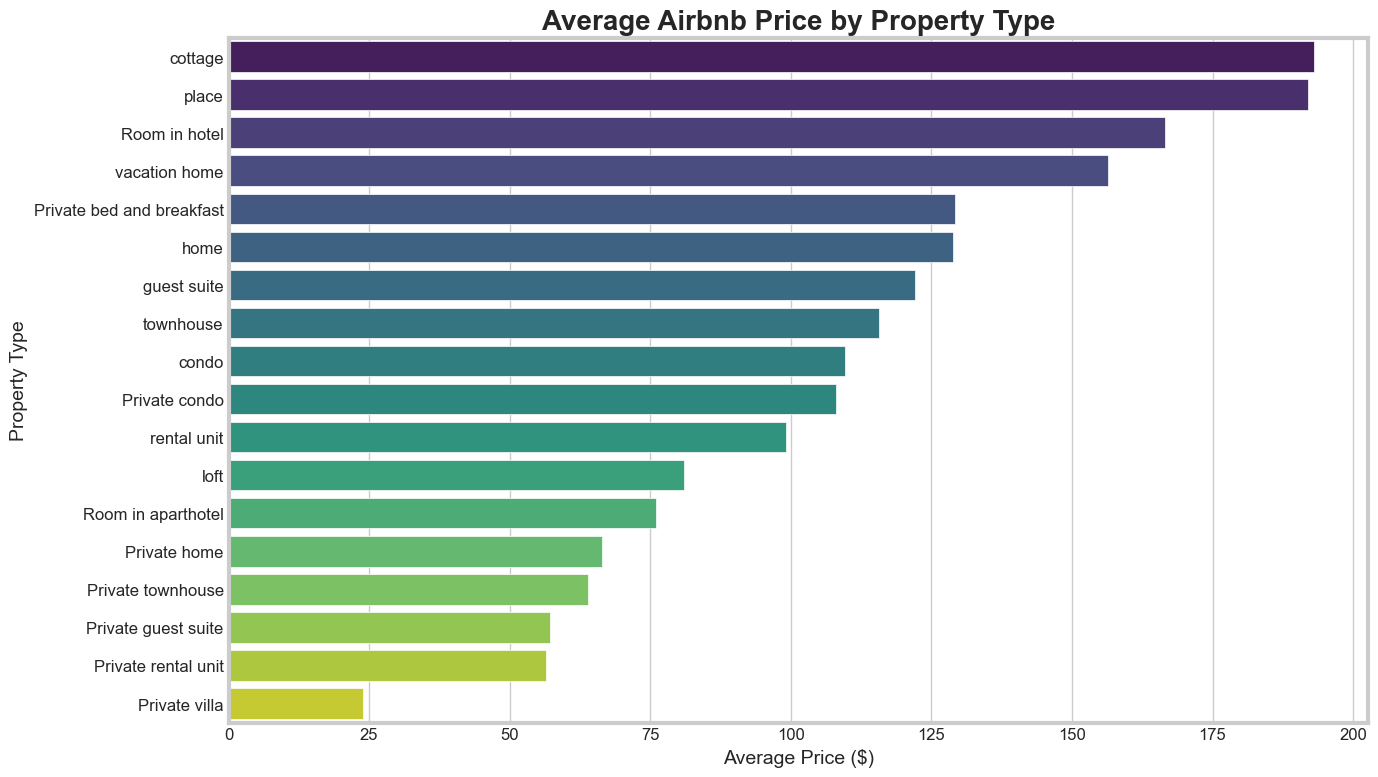

In [46]:
# Plot 1: Refined Bar Chart of Average Price by Property Type
avg_price_by_type = listings_with_features.groupby('property_type_simp')['price'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(14, 8))
sns.barplot(data=avg_price_by_type, x='price', y='property_type_simp', palette='viridis')

plt.title('Average Airbnb Price by Property Type', fontsize=20, weight='bold')
plt.xlabel('Average Price ($)', fontsize=14)
plt.ylabel('Property Type', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### **Step 4: Scale the Features**
Here we scale the new features using MinMaxScaler. This is important because it puts avg_sentiment and distance_to_subway on a common scale from 0 to 1, which is useful for modeling. sentiment_score_scaled will be higher for better reviews, while transit_score will be higher for listings closer to the subway.

In [41]:
scaler = MinMaxScaler()

# Scale sentiment (0 = worst, 1 = best).
listings_with_features["sentiment_score_scaled"] = scaler.fit_transform(
    listings_with_features[["avg_sentiment"]]
)

# Scale transit (0 = farthest, 1 = closest).
listings_with_features["transit_score"] = 1 - scaler.fit_transform(
    listings_with_features[["distance_to_subway"]]
)

# Create a combined quality score for easy visualization.
listings_with_features["quality_score"] = (
    listings_with_features["sentiment_score_scaled"] + listings_with_features["transit_score"]
) / 2

print("Step 3 complete: Features scaled and quality score created.")


Step 3 complete: Features scaled and quality score created.


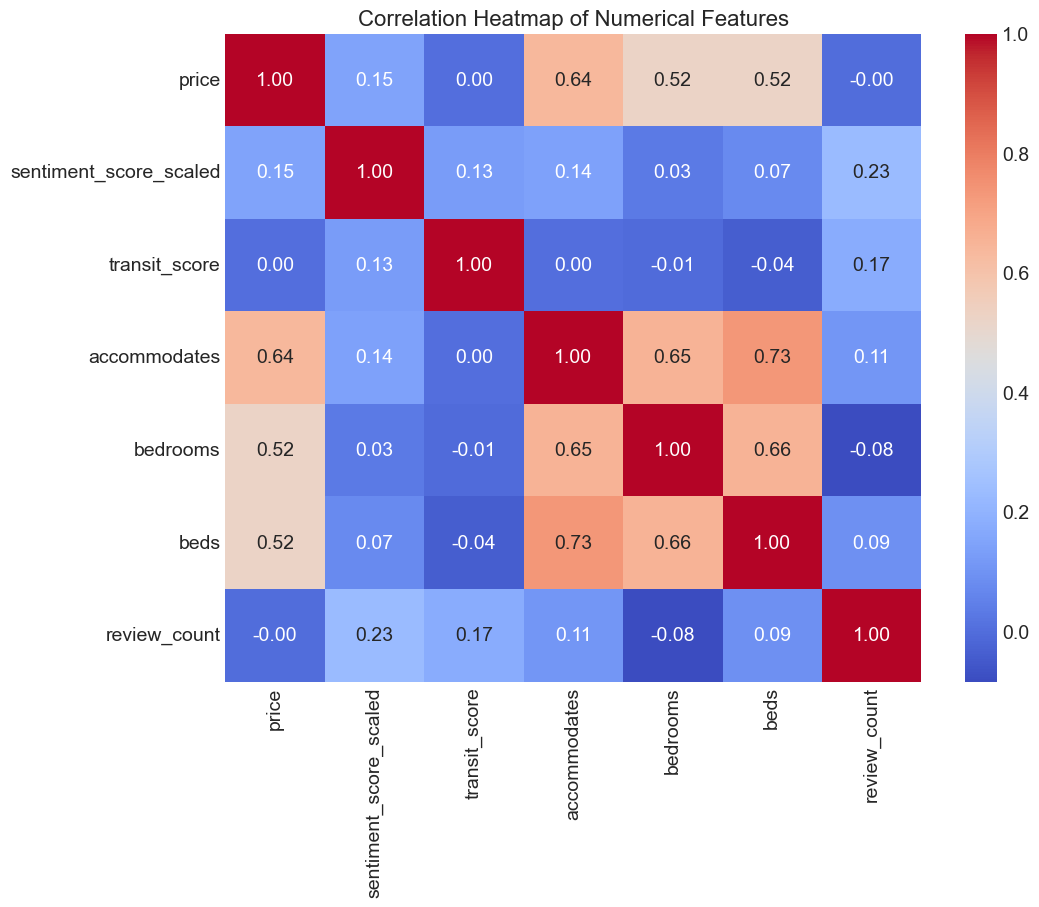

In [44]:
# Import pandas, numpy, and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style
sns.set_style("whitegrid")

# Load the Week 4 dataset
df = pd.read_csv('nyc_airbnb_features_week4.csv')

# Select only the numerical columns for the heatmap
numerical_features = [
    'price',
    'sentiment_score_scaled',
    'transit_score',
    'accommodates',
    'bedrooms',
    'beds',
    'review_count',
]

# Create a correlation matrix
correlation_matrix = df[numerical_features].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

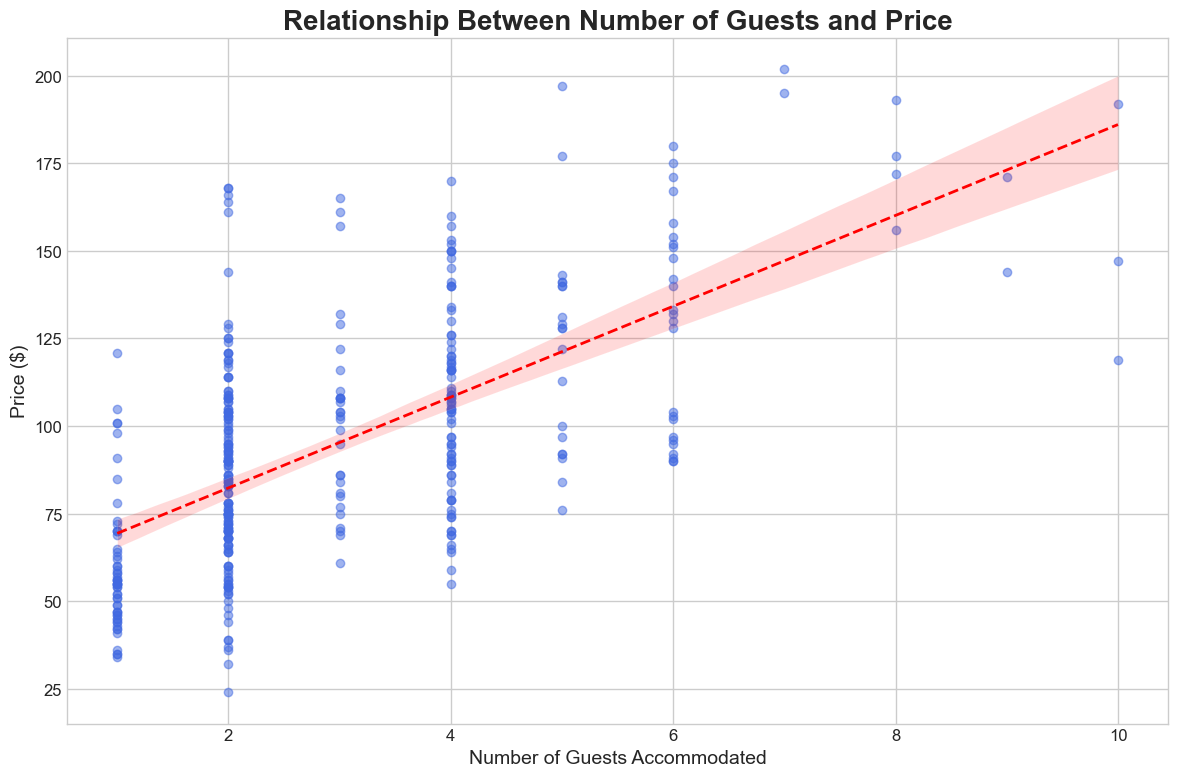

In [47]:

# --- Generate the Professional Plot ---
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")

plt.figure(figsize=(12, 8))
sns.regplot(
    data=listings_with_features,
    x='accommodates',
    y='price',
    scatter_kws={'alpha': 0.5, 'color': 'royalblue'},
    line_kws={'color': 'red', 'lw': 2, 'ls': '--'}
)

plt.title('Relationship Between Number of Guests and Price', fontsize=20, weight='bold')
plt.xlabel('Number of Guests Accommodated', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### **Step 4: Visualize and Save Final Data**


In [42]:
listings_with_features.to_csv('nyc_airbnb_features_week4.csv', index=False)

print("Step 4 complete: Final dataset saved to nyc_airbnb_features_week4.csv")


Step 4 complete: Final dataset saved to nyc_airbnb_features_week4.csv
